In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Baseline Models
- Selects a few stations from the preprocessed Fwy 405 N data
- Uses very basic prediction methods (e.g. using mean values)
- Considers MAE and RMSE on the test data
- Allows us to see baseline accuracy metrics

Note: must run the notebook `/preprocessing/preprocess.ipynb` to get the required data

In [2]:
station_meta = pd.read_csv('../data/processed/fwy-405-n/meta.csv')
station_meta.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name
0,771826,405,N,7,37,43000.0,.11,24.058,33.787054,-118.094505,0.303,ML,4,N. OF 605
1,717696,405,N,7,37,43000.0,.6,24.548,33.791829,-118.100867,0.495,ML,4,STUDEBAKER
2,718219,405,N,7,37,43000.0,1.1,25.048,33.796718,-118.107431,0.565,ML,4,PALO VERDE
3,717701,405,N,7,37,43000.0,1.73,25.678,33.802431,-118.115997,0.675,ML,4,WOODRUFF
4,717703,405,N,7,37,43000.0,2.45,26.398,33.802865,-118.128314,0.505,ML,4,BELLFLOWER 2


In [3]:
station_data = pd.read_csv('../data/processed/fwy-405-n/station-data.csv')
station_data['Time'] = pd.to_datetime(station_data['Time'])
station_data.head()

,Time,Station,Speed
0,2021-05-01,716632,72.2
1,2021-05-01,716659,71.8
2,2021-05-01,716663,69.6
3,2021-05-01,716670,67.7
4,2021-05-01,716689,69.8


In [4]:
# 4 example stations selected at different points along the route
ex_stations = [
    717711, 
    716659, 
    761455, 
    772455
]

station_meta[station_meta['ID'].isin(ex_stations)]

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name
10,717711,405,N,7,37,43000.0,4.57,28.518,33.812037,-118.162485,0.300,ML,4,SPRING
30,716659,405,N,7,37,11530.0,11.82,35.592,33.845809,-118.269724,0.365,ML,5,TRUCK SCALE 1
50,761455,405,N,7,37,NaN,20.39,44.162,33.918874,-118.369550,0.235,ML,4,EL SEGUNDO 2
70,772455,405,N,7,37,44000.0,28.54,52.312,34.019206,-118.423854,0.320,ML,5,PALMS BLVD


### Train Test Split

In [5]:
STATION = ex_stations[3]

# use may, june as train data and july as test data
df = station_data[station_data['Station'] == STATION]
train_data = df[df['Time'] < pd.to_datetime('2021-07-01')]
test_data = df[df['Time'] >= pd.to_datetime('2021-07-01')]

### Mean Fill
Simply predict the mean value

In [6]:
def predict_mean(train_data, test_data):
    mean = np.mean(train_data['Speed'].values)

    return np.array([mean for x in test_data['Time']])

preds = predict_mean(train_data, test_data)

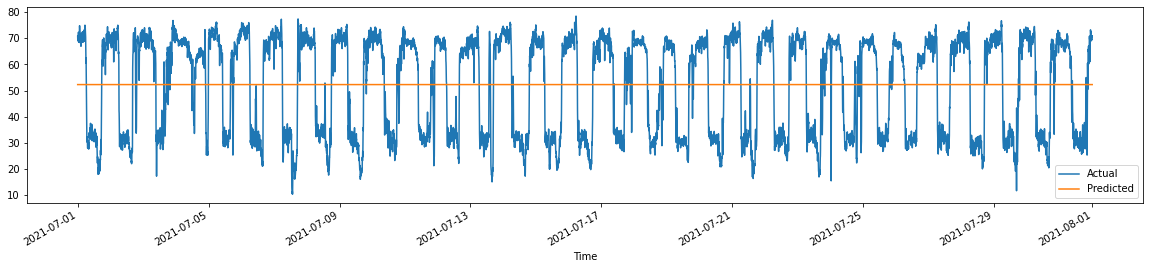

In [7]:
# plot
p = pd.DataFrame(
    {'Actual': test_data['Speed'].values, 'Predicted': preds}, 
    index=test_data['Time'] 
).plot(figsize=(20,4))

In [8]:
# metrics
print('MAE:  %.3f' % mean_absolute_error(test_data['Speed'], preds))
print('RMSE: %.3f' % mean_squared_error(test_data['Speed'], preds, squared=False))

MAE:  17.679
RMSE: 18.615


### Daily Mean
Predict using the mean value based on the time of day

In [9]:
def predict_daily_mean(train_data, test_data):
    df = pd.DataFrame(train_data)
    df['H'] = [x.hour for x in train_data['Time']]
    df['M'] = [x.minute for x in train_data['Time']]
    dm = df.groupby(['H', 'M']).mean()['Speed']

    preds = [dm[x.hour][x.minute] for x in test_data['Time']]  
    return np.array(preds)

preds = predict_daily_mean(train_data, test_data)

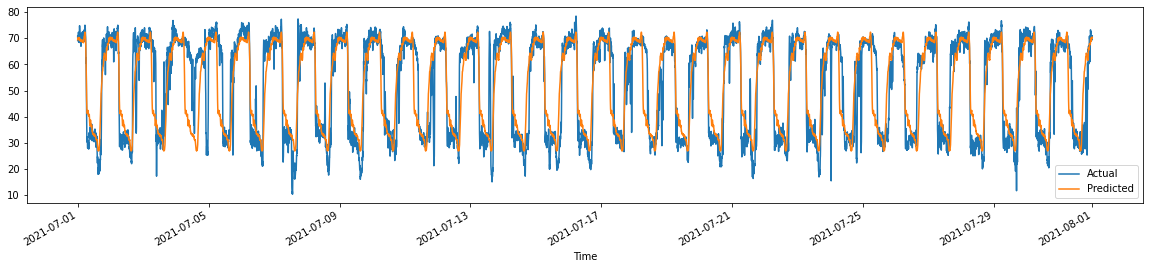

In [10]:
# plot
p = pd.DataFrame(
    {'Actual': test_data['Speed'].values, 'Predicted': preds}, 
    index=test_data['Time'] 
).plot(figsize=(20,4))

In [11]:
# metrics
print('MAE:  %.3f' % mean_absolute_error(test_data['Speed'], preds))
print('RMSE: %.3f' % mean_squared_error(test_data['Speed'], preds, squared=False))

MAE:  6.170
RMSE: 9.767
